<a href="https://colab.research.google.com/github/Shreyansh100704/Stock-Sentiment-Analysis-using-Machine-Learning-Techniques/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from textblob import TextBlob
import re
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from google.colab import files
files.upload()


Saving nyt_headlines_2015_to_2024.csv to nyt_headlines_2015_to_2024.csv


In [ ]:
df = pd.read_csv("nyt_headlines_2015_to_2024.csv")

#If upload does not work, run this code or save the file "nyt_headlines_2015_to_2024.csv" from drive folder and upload it in your notebook using code of 2nd cell.
#df = pd.read_csv("/content/nyt_headlines_2015_to_2024.csv")

In [ ]:
df['Publication Date'] = pd.to_datetime(df['Publication Date'], format='%Y-%m-%dT%H:%M:%S%z')
df["Date"] = df["Publication Date"].dt.strftime("%Y-%m-%d")
df.drop(["Publication Date"], axis=1, inplace=True)
df['headline_num'] = df.groupby('Date').cumcount() + 1
news = df.pivot(index='Date', columns='headline_num', values='Headline')
news.columns = [f'headline_{col}' for col in news.columns]
news = news.fillna("")

In [ ]:
news.tail(3)

,headline_1,headline_2,headline_3,headline_4,headline_5,headline_6,headline_7,headline_8,headline_9,headline_10,...,headline_2001,headline_2002,headline_2003,headline_2004,headline_2005,headline_2006,headline_2007,headline_2008,headline_2009,headline_2010
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-15,‘Doctor Who’ Episode 7 Recap: God of All Gods,Rough Seas Set Back U.S.-Made Gaza Pier Yet Again,Trump Lawyers Argue Barring Attacks on F.B.I. ...,Noted Tempter,Quotation of the Day: Biden Striving for a Foo...,"Corrections: June 15, 2024",A Hungarian Rapper’s Bandwagon Gets an Unlikel...,How a Sauna Master Spends Her Sundays,Spelling Bee Forum,Progressive Democrats Scramble to Save One of ...,...,,,,,,,,,,
2024-06-16,"9 Shot at Splash Park in Michigan, Police Say","Trump, in Pitch to Black Voters in Detroit, Ca...",The Greens Are Dead. Long Live the Greens!,The Tasty New Challenge to Venezuela’s Autocra...,"Corrections: June 16, 2024",Quotation of the Day: The Best Advice for Dads...,"At Biden Fund-Raiser, Hollywood and Democrats ...",A Senseless Fire and the Stranger Who Put It Out,Spelling Bee Forum,"In California, Tribal Members Are Reclaiming t...",...,,,,,,,,,,
2024-06-17,Daniel Radcliffe Conjures Up His First Tony,Chita Rivera’s Life and Career Are Honored at ...,‘House of the Dragon’ Season 2 Premiere: Killi...,‘Stereophonic’ Wins the Tony Award for Best Ne...,‘Merrily We Roll Along’ Was a Flop in 1981. No...,Sarah Paulson Wins Her First Tony for Best Act...,Wildfire Burns Across Southern California,Jonathan Groff’s Star Turn in ‘Merrily We Roll...,"‘The Outsiders,’ a Broadway Adaptation of the ...",Maleah Joi Moon Wins a Tony for Her First Prof...,...,,,,,,,,,,


In [ ]:
#Function to get subjectivity
def getSubjectivity(text):

    return TextBlob(text).sentiment.subjectivity


#Function to get polarity
def getPolarity(text):
    """
        Compute the polarity of a text

    """
    return TextBlob(text).sentiment.polarity


def getSIA(text):
    """
        Compute the sentiments of a text

    """

    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment


def aggregate_sentiment_scores(data):
    """
        Compute the mean of a compound part of sentiment. This gives an idea about overall sentiment

    """

    sentiment_summary = data.groupby('Date')['Compound'].mean()
    return sentiment_summary



In [ ]:
def annualized_returns(data):
    """
        Calculate annualized returns of an investment.

    """

    # Calculate total return
    beginning_value = data['Portfolio_Value (Rs.)'].iloc[0]
    ending_value = data['Portfolio_Value (Rs.)'].iloc[-1]
    total_return = ending_value / beginning_value

    # Calculate the number of years
    num_years = (pd.to_datetime(data["Sell_Date"][len(data)-1]) - pd.to_datetime(data["Buy_Date"][0])).days / 365.25


    # Calculate annualized return
    annualized_return = round(((total_return ** (1 / num_years)) - 1), 4)
    return annualized_return






def sharpe_ratio(data, vol, riskfree_rate=0.07327, periods_per_year=252):
    """
        Compute annualized sharpe ratio
        In India 10 Years Government Bond has a 7.327% yield

    """
    r = data["Returns (%)"]
    rf_per_period = (1+riskfree_rate)**(10/periods_per_year)-1
    annual_excess_returns = annualized_returns(data)
    excess_returns = annual_excess_returns-rf_per_period
    return round((annual_excess_returns/vol), 2)

def drawdown(returns:pd.Series, portfolio_value=10000):
    """
        Computes drawdown

    """

    wealth_index = portfolio_value*(returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.Series(drawdowns)

In [ ]:
def generate_trading_signals(test_data):
    """
        Generate trading signals
        test_data = Data upon which backtesting has to be performed and portfolio has to be created.

    """

    test_data["Signal"] = np.nan
    for i in range(len(test_data)):
        if (test_data['Summary'][i] < -0.9) | (test_data['Summary'][i] > -0.5):
            test_data["Signal"][i] = 1
        elif (-0.5 > test_data['Summary'][i] > -0.6) | (test_data['Summary'][i] > 0.2):
            test_data["Signal"][i] = -1
        else:
            test_data["Signal"][i] = "Hold"
    return test_data


def simulate_trades(stock_data, trading_signals):
    """
        Simulation of trades by analyzing trading signals
        stock_data = Data upon which backtesting has to be performed and portfolio has to be created.
        trading_signals = Signals generated by generate_trade_signals() function.

    """

    pf_buy = []
    pf_sell = []
    initial_pf = 10000
    position = 0
    buy_price = 0
    summary_sentiment = stock_data['Summary']

    for date, price in stock_data['Close'].items():
        if date in trading_signals.index:
            signal = trading_signals.loc[date]
            summary = summary_sentiment.loc[date]
            if signal == 1 and position == 0:  # Buy signal
                position = 1
                buy_price = round(price, 2)
                n_stocks = initial_pf//price
                invested = round((n_stocks*price), 2)
                rem = round((initial_pf - invested), 2)
                pf_buy.append({"Opening_Balance (Rs.)": initial_pf, "No_of_stocks": n_stocks, "Buy_Date": date, "Buy_Price (Rs.)": buy_price, "Invested (Rs.)": invested, "Summary_Buy": summary})
            elif signal == -1 and position == 1:  # Sell signal
                position = 0
                sell_price = round(price, 2)
                profit = round(((sell_price - buy_price)*n_stocks), 2)
                initial_pf = round(((sell_price*n_stocks) + rem), 2)
                returns = round(((profit/invested)*100), 2)

                pf_sell.append({"Sell_Date": date, "Sell_Price (Rs.)": sell_price, "Profit (Rs.)": profit,"Returns (%)": returns, "Portfolio_Value (Rs.)": initial_pf, "Summary_Sell": summary})
    portfolio = pd.DataFrame(pf_buy).merge(pd.DataFrame(pf_sell), how='inner',right_index=True, left_index=True)
    return pd.DataFrame(portfolio)



In [ ]:
def calculate_portfolio_metrics(test_data, stock_name):
    """
        Gives portfolio metrics such as returns, profit, etc.
        test_data = Data upon which backtesting has to be applied
        stock_name = Name of the stock upon which testing occurred

        This fuction saves the csv file of portfolio, print the metrics and plots the graph showing buying and selling points.

    """

    test_data = generate_trading_signals(test_data)
    portfolio = simulate_trades(test_data, test_data["Signal"])

    wins = []
    total_trades = len(portfolio)
    sigma = test_data['Daily Return'].std()
    vol =  sigma*(252**0.5)    #Gives annualized volatility
    for i in range(total_trades):
        if portfolio['Profit (Rs.)'][i] > 0:
            wins.append(1)
    win_pct = round((len(wins)/total_trades)*100, 2)
    total_profit = round(portfolio['Profit (Rs.)'].sum(), 2)
    dd = drawdown(portfolio['Returns (%)'])
    if (dd.min() == 0):
        max_dd = 0
    else:
        max_dd = -(round(dd.min(), 2))
    highest_profit = round(((portfolio['Returns (%)'].max())),2)
    highest_loss = round(((portfolio['Returns (%)'].min())),2)
    ann_return = (annualized_returns(portfolio))*100
    sharpe__ratio = sharpe_ratio(portfolio, vol)
    pf_ret = round(((total_profit/10000)*100), 2)

    print("No. of Buy ", total_trades)
    print("No. of Sell ", total_trades)
    print("No. of executed trades are ", total_trades*2)
    print("Win ", win_pct, "%")
    print("Total profit is Rs.", total_profit)
    print("Total portfolio return is ", pf_ret, "%")
    print("Maximum Drawdown is ", max_dd, "%")
    print("Highest profit in single trade is ", highest_profit, "%")
    print("Highest loss in single trade is ", highest_loss, "%")
    print("Annualized return is ", ann_return, "%")
    print("Sharpe ratio is ", sharpe__ratio)


    # Save Portfolio to CSV
    portfolio.to_csv(stock_name[:-3] + '_Portfolio.csv', index=False)


    #Plot graph showing Buying and Selling points
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data['Close'], label='Close Price', alpha=0.7)
    plt.scatter(portfolio['Buy_Date'], portfolio['Buy_Price (Rs.)'], label='Buying Point', marker='^', color='green', alpha=1)
    plt.scatter(portfolio['Sell_Date'], portfolio['Sell_Price (Rs.)'], label='Selling Point', marker='v', color='red', alpha=1)
    plt.title('Buying and Selling Points for ' + stock_name[:-3])
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [ ]:
def train_model(news, stock_name, date, model_name, time_for_backtesting = 2):
    """
        Train the model and show classification report.
        news = Pass the dataset of news headlines
        stock_name = Name of the stock upon which testing occurred
        date = The date from which the news is available in the dataset
        model_name = Give the model for training the dataset
        time_for_backtesting = Years upto which backtesting has to be performed

        Returns: test_data

    """

    stock = yf.download(stock_name, date)
    stock.index = stock.index.strftime("%Y-%m-%d")   #Re-formatting index
    data = news.merge(stock, how='inner',right_index=True, left_index=True)
    data['Price_Increase'] = (data['Adj Close'] > data['Adj Close'].shift(1)).astype(int)

    #Re-positioning the Price_Increase column to 1st column
    columns = list(data.columns)
    columns.insert(0, columns.pop(columns.index('Price_Increase')))
    data = data[columns]

    #Create a single column consisting all headlines separated by a space
    headlines = []
    for i in range(0, len(data.index)):
        headlines.append(' '.join(str(x) for x in data.iloc[i, 1:2010]))
    data["Combined_News"] = headlines

    #Cleaning the texts
    clean_headlines = []
    for i in range(len(headlines)):
        clean_headlines.append(re.sub("â[(€)]", "'", headlines[i]))  #Replace â€ with '
        clean_headlines[i] = re.sub("™", "", clean_headlines[i])     #Remove ™
        clean_headlines[i] = re.sub("˜", "", clean_headlines[i])     #Remove ˜
        clean_headlines[i] = re.sub("¦", "", clean_headlines[i])     #Remove ¦

    data["Clean_Combined_News"] = clean_headlines


    #Create two new columns 'Subjectivity' and 'Polarity'
    data['Subjectivity'] = data['Clean_Combined_News'].apply(getSubjectivity)
    data['Polarity'] = data['Clean_Combined_News'].apply(getPolarity)

    #Get the sentiment scores for each day
    compound = []
    neg = []
    pos = []
    neu = []
    sentiment = []
    SIA = 0

    for i in range(len(data['Clean_Combined_News'])):
        SIA = getSIA(data['Clean_Combined_News'][i])
        sentiment.append(SIA)
        compound.append(SIA['compound'])
        neg.append(SIA['neg'])
        pos.append(SIA['pos'])
        neu.append(SIA['neu'])

    #Store the sentiment scores in the dataset
    data['Compound'] = compound
    data['Negative'] = neg
    data['Neutral'] = neu
    data['Positive'] = pos

    #Retaining essential parameters required for training the model
    X = data[['Open', 'High', 'Low', 'Volume', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
    y = data['Price_Increase']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(time_for_backtesting/10), shuffle=False)
    model = model_name
    model.fit(X_train, y_train)
    predictions = model.predict(X_test).round()

    predictions_prob = model.predict(X_test)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, predictions_prob)
    roc_auc = auc(fpr, tpr)


    close = data[["Close"]]
    test_data = X_test.merge(close, how='inner',right_index=True, left_index=True)
    summary = aggregate_sentiment_scores(test_data)
    test_data["Summary"] = summary
    test_data['Daily Return'] = test_data['Close'].pct_change()



    print(classification_report(y_test, predictions))

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return test_data

**TESTING STARTS**

[*********************100%%**********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.84      0.82      0.83       223
           1       0.84      0.86      0.85       244

    accuracy                           0.84       467
   macro avg       0.84      0.84      0.84       467
weighted avg       0.84      0.84      0.84       467



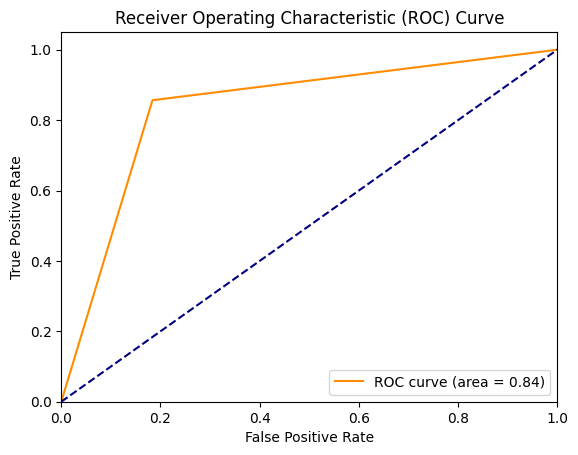

In [ ]:
stock_1 = 'TATAMOTORS.NS'
test_data_1 = train_model(news, stock_1, '2015-01-01', LogisticRegression())

No. of Buy  5
No. of Sell  5
No. of executed trades are  10
Win  80.0 %
Total profit is Rs. 10809.75
Total portfolio return is  108.1 %
Maximum Drawdown is  0 %
Highest profit in single trade is  37.15 %
Highest loss in single trade is  -10.32 %
Annualized return is  55.720000000000006 %
Sharpe ratio is  2.11


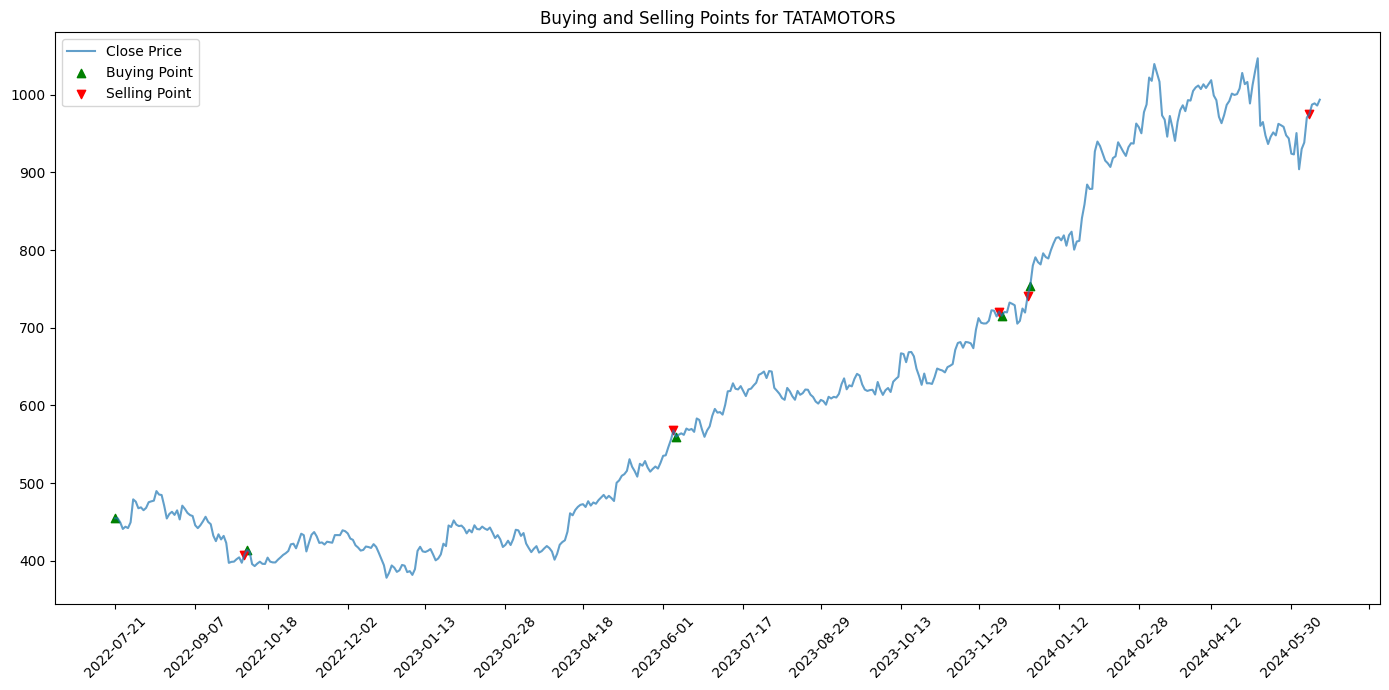

In [ ]:
calculate_portfolio_metrics(test_data_1, stock_1)

[*********************100%%**********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       214
           1       0.82      0.82      0.82       253

    accuracy                           0.80       467
   macro avg       0.80      0.80      0.80       467
weighted avg       0.80      0.80      0.80       467



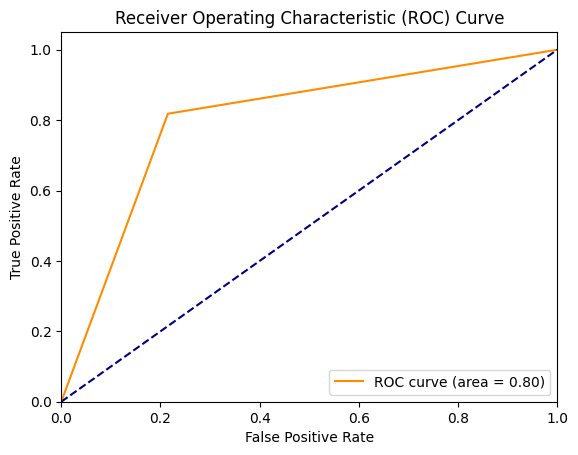

In [ ]:
stock_2 = 'COALINDIA.NS'
test_data_2 = train_model(news, stock_2, '2015-01-01', LogisticRegression())

No. of Buy  5
No. of Sell  5
No. of executed trades are  10
Win  80.0 %
Total profit is Rs. 12558.65
Total portfolio return is  125.59 %
Maximum Drawdown is  8741.4 %
Highest profit in single trade is  55.04 %
Highest loss in single trade is  -1.2 %
Annualized return is  44.65 %
Sharpe ratio is  1.52


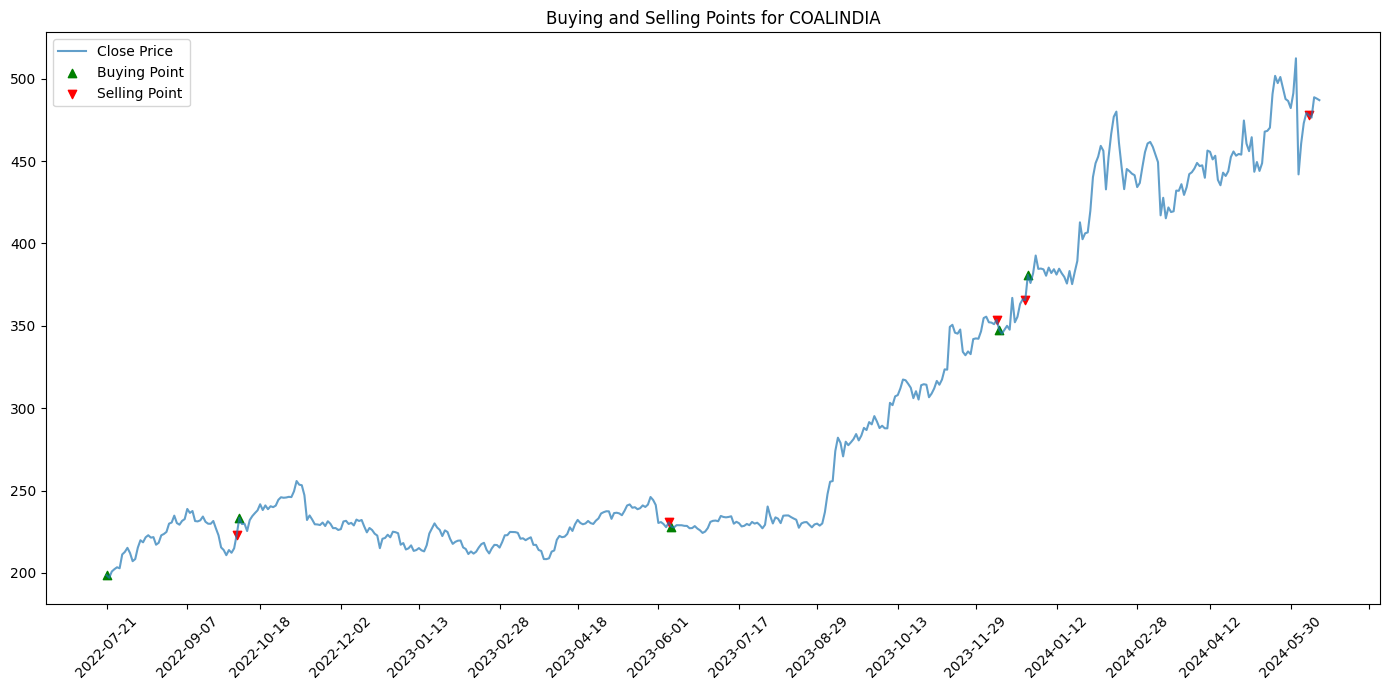

In [ ]:
calculate_portfolio_metrics(test_data_2, stock_2)

[*********************100%%**********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.79      0.78      0.78       213
           1       0.82      0.82      0.82       254

    accuracy                           0.80       467
   macro avg       0.80      0.80      0.80       467
weighted avg       0.80      0.80      0.80       467



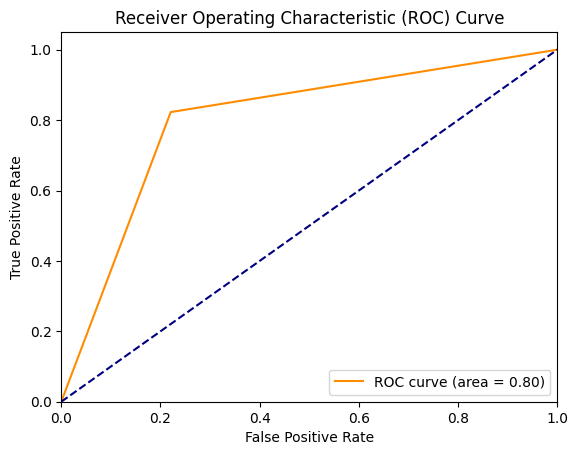

In [ ]:
stock_3 = 'BAJAJ-AUTO.NS'
test_data_3 = train_model(news, stock_3, '2015-01-01', LogisticRegression())

No. of Buy  5
No. of Sell  5
No. of executed trades are  10
Win  80.0 %
Total profit is Rs. 11063.2
Total portfolio return is  110.63 %
Maximum Drawdown is  0 %
Highest profit in single trade is  45.2 %
Highest loss in single trade is  -11.77 %
Annualized return is  56.43 %
Sharpe ratio is  2.56


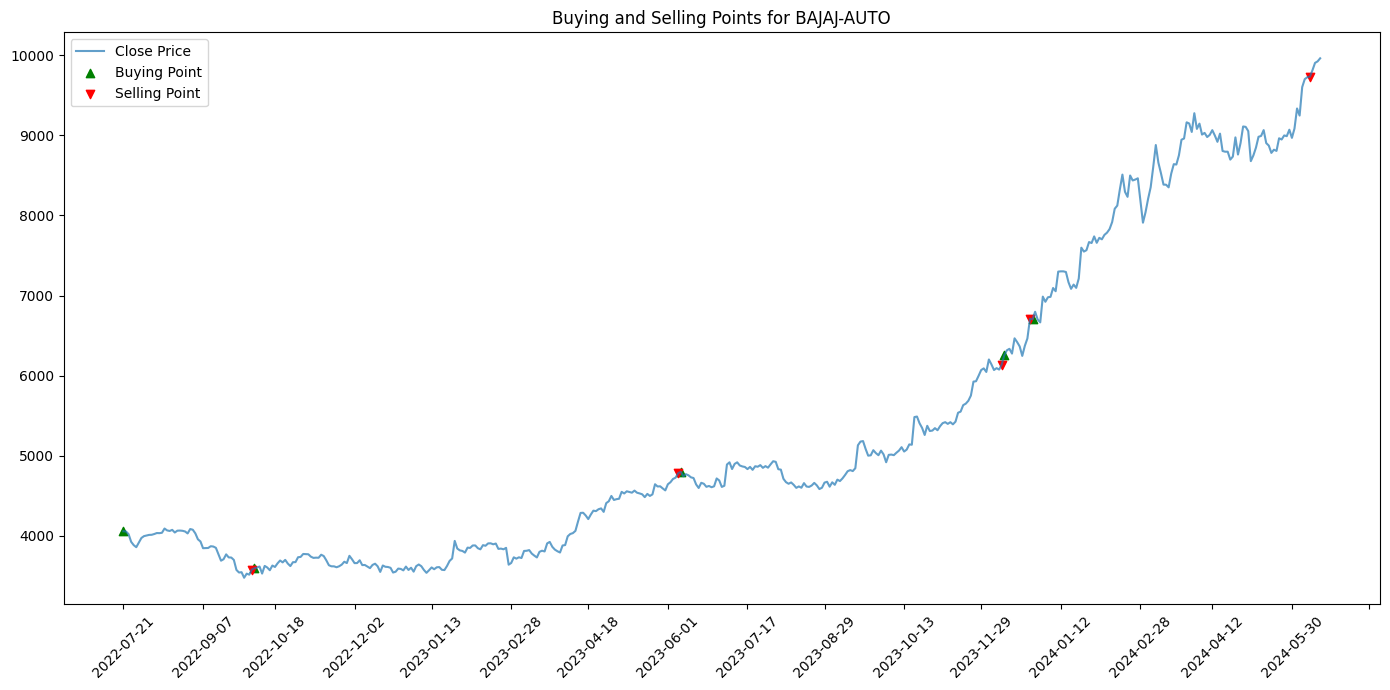

In [ ]:
calculate_portfolio_metrics(test_data_3, stock_3)

[*********************100%%**********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.76      0.81      0.78       556
           1       0.82      0.77      0.79       610

    accuracy                           0.79      1166
   macro avg       0.79      0.79      0.79      1166
weighted avg       0.79      0.79      0.79      1166



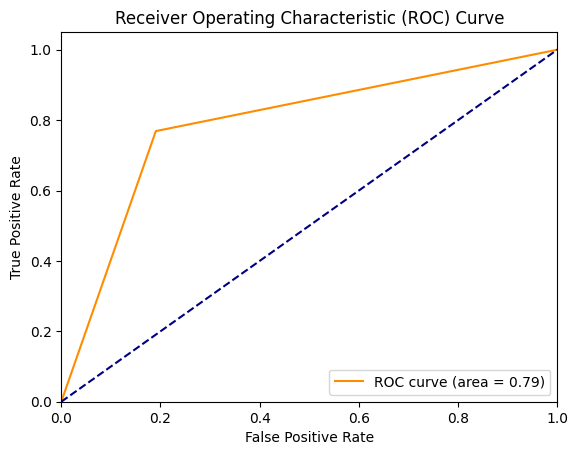

In [ ]:
stock_4 = 'LT.NS'
test_data_4 = train_model(news, stock_4, '2015-01-01', LogisticRegression(), 5)

No. of Buy  8
No. of Sell  8
No. of executed trades are  16
Win  75.0 %
Total profit is Rs. 13868.1
Total portfolio return is  138.68 %
Maximum Drawdown is  0.27 %
Highest profit in single trade is  118.43 %
Highest loss in single trade is  -42.75 %
Annualized return is  33.08 %
Sharpe ratio is  1.15


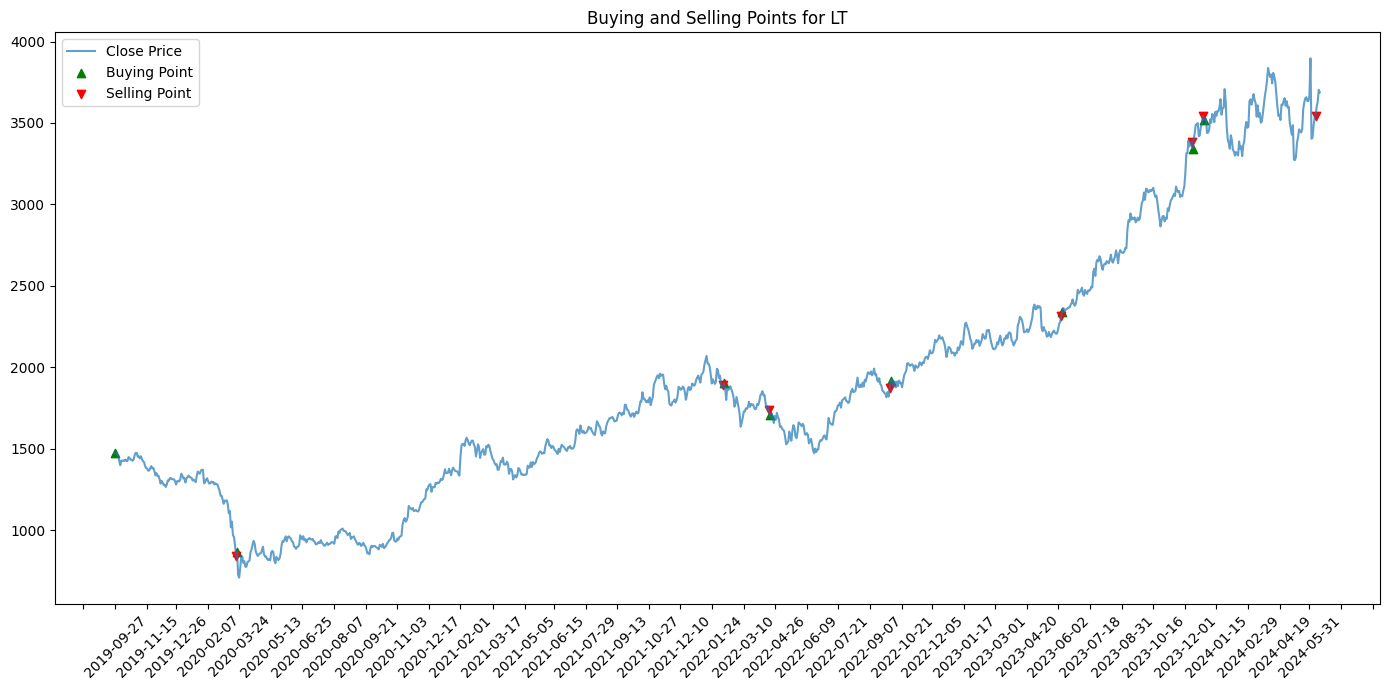

In [ ]:
calculate_portfolio_metrics(test_data_4, stock_4)

[*********************100%%**********************]  1 of 1 completed


              precision    recall  f1-score   support

           0       0.81      0.72      0.76       554
           1       0.77      0.85      0.81       612

    accuracy                           0.79      1166
   macro avg       0.79      0.78      0.78      1166
weighted avg       0.79      0.79      0.79      1166



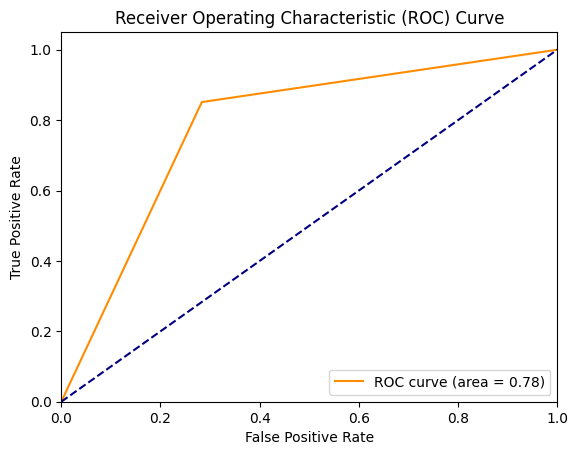

In [ ]:
stock_5 = 'SUNPHARMA.NS'
test_data_5 = train_model(news, stock_5, '2015-01-01', LogisticRegression(), 5)

No. of Buy  8
No. of Sell  8
No. of executed trades are  16
Win  87.5 %
Total profit is Rs. 27206.9
Total portfolio return is  272.07 %
Maximum Drawdown is  0 %
Highest profit in single trade is  142.7 %
Highest loss in single trade is  -10.28 %
Annualized return is  35.19 %
Sharpe ratio is  1.33


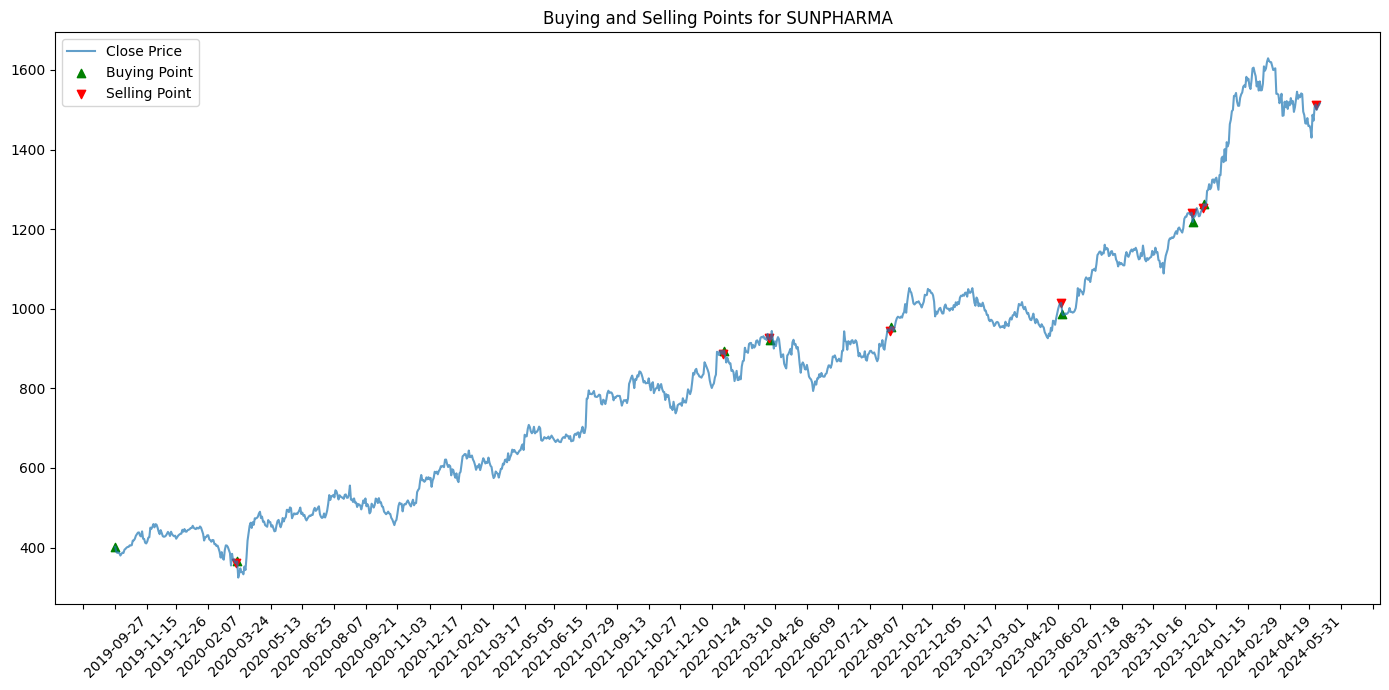

In [ ]:
calculate_portfolio_metrics(test_data_5, stock_5)